<h1 style="font-size:35px;"><center>Variational Autoencoders</center><br><center>in</center><br><center>Imputation</center>
</h1>

<h1 style="font-size:20px;"><center>Najmeh Abiri</center>
</h1>




# Introduction and Methodology 
A [Variational autoencoer (VAE)](https://arxiv.org/abs/1312.6114) is a Bayesian Neural Network, that has been introduced recently as a generative model. Unlike a [vanilla autoencoder](https://dl.acm.org/citation.cfm?id=1390294) which maps given data to a point estimation, a VAE maps to a distribution over the data.

Autoencoders contain two mapping parts, an encoder and decoder. The encoder maps the network's input, the data, into a latent representation called a z-space. The decoder then maps the the z-space back to a reconstruction of the input.


![](data/ae.png "Deterministic Autoencoder")<center>_Deep Autoencoder_ [_image source_](http://blog.fastforwardlabs.com/)</center>


In this image the smallest hidden layer in the middle of the network is the latent representation of the network's input. To force the network to learn the useful representation, several regularization hyper-parameters are applied in the network's architecture. 

Since the VAE maps both encoder and decoder to distributions, the description of these two steps are as follows:

 - The encoder : $q(z \mid x,\phi)$, which infer the posterior destribution $p(z \mid x)$ with Variational Inference.
 - The decoder : $p(x \mid z,\theta)$, which gives the data distribution from z-space.
 
![](data/vae.png "Variational Autoencoder")<center>_Variational Autoencoder_ [_image source_](http://blog.fastforwardlabs.com/)</center> 
 

Both of these probabilities are neural networks with $\theta$ and $\phi$ as their parameters. In the encoder, the main idea of Variational Inference is to pose the inference by approaching it as an optimization problem. This means, we model the true distribution $p(z \mid x)$, as a simpler distribution like **Gaussian**. Then by minimizing the difference between these two distributions, using **KL divergence**, we eventually reach the lower bound of the posterior. 



## VAE Loss and Regularization
Like other Bayesian models, a VAE is reguralized by it's priors. It regularizes by learning the joint distribution over data and pre-defined latent variables. As mentioned before the designated prior distribution over latent space is **Gaussian**.

With the **KL divergence** formula we have

$$D_{KL}[  q(z \mid X) \parallel p(z \mid X)] = \sum_z q(z \mid X) log \frac{q(z \mid X)}{p(z \mid X)}.$$

That is,

$$log( p(X)) - D_{KL}[  q(z \mid X) \parallel p(z \mid X)] = E[log p(X \mid z)] - D_{KL}[  q(z \mid X) \parallel p(z)] $$

## Imputation

Dealing with missing data in any data analysis is inevitable. Here, we define some random corruption over MNIST data set, then we try to impute the corrupted missing data, by using a VAE.

# Model Structure and Code

The main pipline of the network is a class named VAE, which is in the file **imp_vae.py**. Here is a pseudo algorithm of the VAE class:
<img src=data/vae_alg.png  width="50%"><center>_VAE Class_</center> 
 
To see the code please remove the comment:

In [1]:
#!cat data/imp_vae.py

In [2]:
from __future__ import division, absolute_import
from __future__ import print_function, unicode_literals
import os
os.environ['KERAS_BACKEND']='tensorflow'


import numpy as np
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


inlin = False
if inlin:
    %matplotlib inline
else:
    %matplotlib notebook


from functools import partial

from keras.models import load_model
from keras.datasets import mnist
import keras.backend as K


from data.imp_vae import VAE

Using TensorFlow backend.
/home/najmeh/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In this step we load the [**MNIST**](http://yann.lecun.com/exdb/mnist/) data, which contains $70000$ hand written samples. It has been divided into training and testing sets.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('\n training data shape: ', x_train.shape,
      '\n testing data shape: ',x_test.shape)


 training data shape:  (60000, 28, 28) 
 testing data shape:  (10000, 28, 28)


In order to produce a new random variable degree corruption, one can set **new_mask** variable to **True** in the cell below:

In [4]:
def line_mask(data, mis):
    mask = np.ones_like(data, dtype = np.float32)    
    for i,img in enumerate(data):
        s = int(round(28 * (mis/2)))
        #r_mask = np.random.choice(np.arange(0,28), size=s, replace=False)
        #c_mask = np.random.choice(np.arange(0,28), size=s, replace=False)
        r_mask = np.random.randint(5, 23, size= s)
        c_mask = np.random.randint(8, 20, size= s)

        mask[i,r_mask, :] = .0
        mask[i,:, c_mask] = .0
            
    #flatten    
    mask = mask.reshape((len(mask), np.prod(mask.shape[1:])))
    return mask


def pixel_mask(data, mis):    
    mask = np.random.binomial(n = 1, p=1-mis, size=data.shape)
    mask = mask.reshape((len(mask), np.prod(mask.shape[1:])))
    return mask


new_mask = False
if new_mask:
    train_mask=[]
    test_mask=[]
    for mis in np.arange(.1, 1., .1):        
        train_mask.append( line_mask(x_train, mis) )
        test_mask.append( line_mask(x_test, mis) )
    np.savez_compressed('data/mask', train =train_mask, test=test_mask )
 

mask = np.load('data/mask.npz')    
train_mask , test_mask = mask['train'] ,  mask['test']


print('\n training mask shape: ', train_mask.shape,
      '\n testing mask shape: ',test_mask.shape)


 training mask shape:  (9, 60000, 784) 
 testing mask shape:  (9, 10000, 784)


Before starting the network training, one should consider the normalization and the shape of the dataset. The data contains black and white pixels and we assume a normal distribution, so by applying _standard score_ the network trains with less computations. One can also flatten the data into vectors to lower the data dimensions.

In [5]:
## Normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
## Flatten
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### plotting the latent space

After training the model with each specific setting and fractions of corruption, one can plot the latent space with the following function.

The plots show the clustering of classes.

In [6]:
def plot_latent(mis, model):
    z_mu = model.predict(x_test, batch_size=batch_size)[0]

    ###3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:, 2],
                   c=y_test, 
                   cmap='tab10')
    fig.colorbar(p, ticks=range(10))
    plt.suptitle('Latent Plot with corruption {}'.format(mis))
    plt.axis('off')      

## Generating Samples

One of the most important difference between a VAE and a AE is that with a trained VAE one can generate instances of the object that do not exist in the training data. This is one way to investigate what the VAE has learned. Here we have a function which generates numbers of objects with $X \sim \mathcal{N}(\mu = 0,\,\sigma^{2}=1)$. 

In [7]:
def generate_from_latent(mis, model):
    z = hyper_param['h_encod'][-1]
    fig, axes = plt.subplots(5)
    for j in range(5):
        
        recons = model.predict([ np.zeros((1,z)), np.ones((1,z)) ])
        axes[j].set_axis_off()
        axes[j].imshow(recons.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.suptitle('Generate from Latent with corruption {}'.format(mis))

## Quantifying uncertainty

An important application of autoencoders is data imputation. AE does not consider the uncertaintly in imputation missing data, since there is not a correct answer, and it forces the model to give a deterministic answer. However, a VAE recognises this ambiguity and considers it in the resulting distribution. This means that the model is more robust to errors. 

In [8]:
def sample_test(mis,imx = [212,23], t = 4):
    time = 2 + t
    ll = int(mis*10)-1
    f, ax = plt.subplots(len(imx), time)

    for m,im in enumerate(imx):    
        sample = x_test[im].reshape(1,784)
        mask = test_mask[ll, im].reshape(1,784)

        ax[m,0].set_axis_off()
        ax[m,0].set_title('original')
        ax[m,0].imshow( (sample).reshape(28, 28), cmap="gray")
        ax[m,1].set_axis_off()   
        ax[m,1].set_title('input')
        ax[m,1].imshow( (sample * mask).reshape(28, 28), cmap="gray")

        
        for i in range(2, time):
            rec = vae.vae_model.predict([sample * mask, mask ])
            ax[m,i].set_axis_off()
            ax[m,i].set_title('samp_{}'.format(i-1))
            ax[m,i].imshow(rec.reshape(28, 28), vmin=0, vmax=1,cmap="gray")
    plt.suptitle('Uncertainty with corruption {}'.format(mis))

## Training the model
Finally we can train the network pipline with a different **missing fraction**. Since training is time consuming, the models with corruption of $[0.2,0.5]$ have been saved and will be load in the next cell to evaluate.

In case user wants to retrain the model, set the _train_ variable to _True_.

In [9]:
missing_percent=[0.2,0.7]
print('#'*30)
print(' '*10, 'TRAINING')
print('#'*30)

epochs = 50
batch_size = 500
hyper_param = {'h_encod' : [400,200,3],
               #'h_decod' : [3,400],
               'drop':  [.0, .0, .0],
               'act_f' : 'relu', 
               'optimiz' : 'adam',
               'inp_shape' : x_train.shape[1],
               'lr_rate': 1e-2
                }


train = True
if train:
    
    for mis in missing_percent:
        m = int(mis*10)-1
        print('-'*30)
        print('\nmissing percentage: {} .. \n'.format(mis))

        vae = VAE(hyper_param)
        vae.vae_model.fit([x_train * train_mask[m], train_mask[m]],
                          [x_train * train_mask[m]],
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=([x_test, test_mask[m]] , x_test * test_mask[m]),
                          verbose = 0)
        print('\n.. model training done\n'.format(mis))
        print('-'*30)
       
        vae.generator.save('data/generator_{}.h5'.format(mis))
        vae.recognition.save('data/recognition_{}.h5'.format(mis))
        #del vae.vae_model


##############################
           TRAINING
##############################
------------------------------

missing percentage: 0.2 .. 


.. model training done

------------------------------
------------------------------

missing percentage: 0.7 .. 


.. model training done

------------------------------


#### Comparing uncertenty between different corruptions

With _sample test_ function we can compare the results of different corruption. One can see with increasing the corruption the samples become thicker which shows a higher uncertainty on the model decision.


<IPython.core.display.Javascript object>


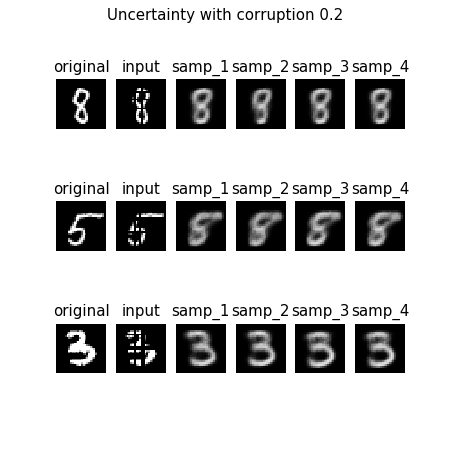

<IPython.core.display.Javascript object>


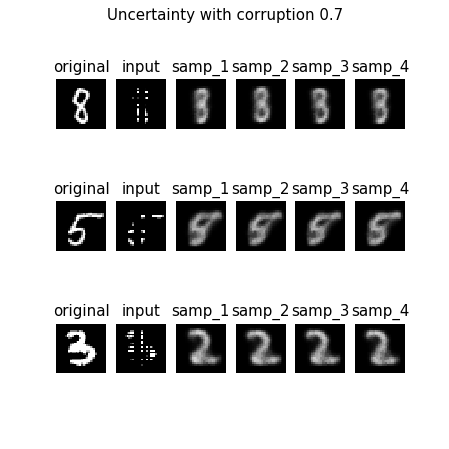

In [13]:
for mis in missing_percent:
    mpl.rcParams['figure.figsize'] = (5,5)
    sample_test(mis,[621,152,801]) #221
plt.show()

## Loading models

In the cell below we load both model for different missing percentage and first **generate data from the latent space**.

/home/najmeh/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<IPython.core.display.Javascript object>


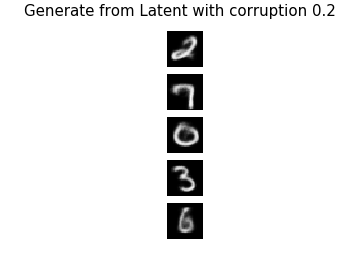

<IPython.core.display.Javascript object>


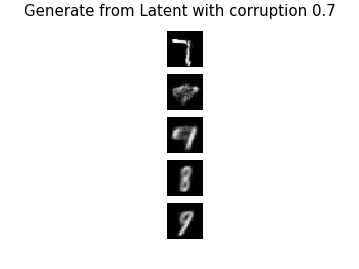

In [11]:
mpl.rcParams['figure.figsize'] = (4,3)

for mis in missing_percent:
    generator = load_model('data/generator_{}.h5'.format(mis))
    generate_from_latent(mis, generator)

plt.show()

### Recognition Model

By plotting the latent space which has been defined with 3 nodes, the clustering of different classes of numbers are observable.

/home/najmeh/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<IPython.core.display.Javascript object>


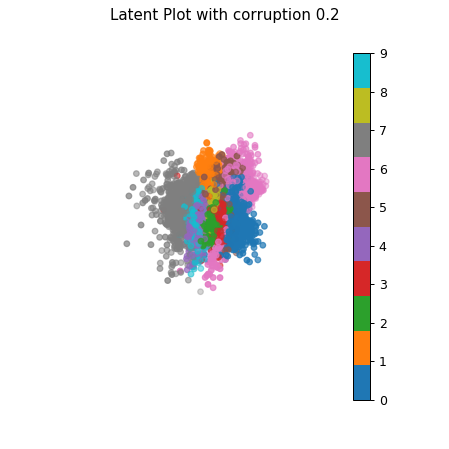

<IPython.core.display.Javascript object>


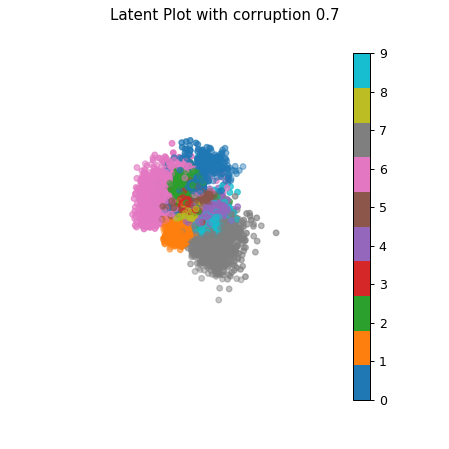

In [12]:
mpl.rcParams['figure.figsize'] = (5,5)

for mis in missing_percent:
    recog = load_model('data/recognition_{}.h5'.format(mis))#, custom_objects={'masked_centropy': custom_loss})
    plot_latent(mis ,recog)
plt.show()

# Outlook

In this study we did not use any technique, to evaluate predictive models due to high computational cost, one such technique could be cross validation. Also we did not go further to perform classification and compare the VAE to other imputation methods which will be done in future.
